<img src="https://www.imt-atlantique.fr/sites/default/files/Images/Ecole/charte-graphique/IMT_Atlantique_logo_RVB_Baseline_400x272.jpg">

# Journey to Data Scientist : le cas Ulule

## Introduction - Business understanding

Dans la présente étude nous nous considérons comme une équipe de data scientists travaillant pour Ulule. L'objectif sera d'élaborer un modèle de machine learning permettant de prédire ou non le succès d'une campagne de crowdfunding à partir de données de la campagne; et de conseiller l'utilisateur derrière la campagne sur ce qu'il peut améliorer.

Dans la mesure où Ulule se rémunère en touchant une commission sur les projets ayant fonctionné, le site a tout intérêt à ce qu'un maximum de projets réussissent.

###### Note :
Cette étude est basée principalement sur un set de données obtenu via l'API publique d'Ulule, avec l'autorisation du site par e-mail.
Une vérification du set sera effectuée afin de ne pas traiter de données personnelles.

## Import des données

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
import csv
from scipy.stats import pearsonr,spearmanr
from datetime import datetime


pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv("./ulule_data.csv", low_memory=False)

In [3]:
data = df.copy(deep=True) # Relancer cette cellule pour reload data sans ouvrir le csv !

## Vérification du set de données - Data understanding

Dans la mesure où certains projets peuvent ou non avoir une vidéo de présentation, il est exclu de retirer toute ligne contenant un "NaN" (représentant un vide). On se contente donc de retirer les doublons et les colonnes constantes, dans un premier temps.

In [4]:
data.drop_duplicates(inplace=True)  # Retrait de doublons.
data = data.loc[:, (data != data.iloc[0]).any()]  # Retrait de colonnes constantes

Fonctions utiles pour tout le projet :

In [5]:
def pie_feature(feature_name, title):
    plt.figure()
    plt.suptitle(title)
    valeurs = data[feature_name].value_counts() #on compte le nombre de personnes qui ont chaque feature
    plt.pie(valeurs, labels=valeurs.index, autopct='%1.2f%%')
    plt.show()
    
def plot_feature(feature_name, title, xlabel, ylabel):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    plt.suptitle(title)
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.plot(data.id, data[feature_name], "+")

    sns.boxplot(y=data[feature_name], ax=ax2)
    ax2.set_ylabel("")
    plt.show()

### Première analyse du set

Le set contient près de 50000 lignes correspondant à des projets, réussis ou non, et 96 colonnes contenant différents éléments comme le montant levé ou la description du projet dans différentes langues.

Les colonnes peuvent être groupées en quatre catégories :
- les données construites par Ulule (comme des listes d'urls)
- les données obsolètes ou constantes et qui seront retirées
- les données liées au projet (avant le lancement)
- les données liées à la campagne (après le lancement)

#### Données construites par Ulule

Ces données sont indépendantes du possesseur du projet (l'utilisateur que nous cherchons à conseiller) et <b>ne seront donc pas utilisées dans cette étude</b>.
- ~absolute_url~
- ~discussion_thread_id~
- id
- ~resource_uri~
- ~slug~
- ~urls~
- ~user_role~

L'id du projet sera conservé pour disposer d'une variable indépendante du projet et simple à représenter, en abscisse notamment.

#### Données obsolètes ou inutiles

Ces données proviennent d'anciennes versions de l'API ou sont constantes quelque soit le projet (dans ce data set) et sont donc à retirer.

- ~address_required~
- ~permissions~
- ~phone_number_required~
- ~required_personal_id_number~
- ~image~
- ~status~
- ~is_in_extra_time~

#### Données du projet

Ces données concernent le projet après son lancement.

- amount_raised
- comments_count
- ~committed~
- date_end
- date_end_extra_time
- date_goal_raised
- date_start
- fans_count
- ~finished~
- ~is_cancelled~
- ~is_in_extra_time~
- ~lowest_contribution_amount~
- nb_days
- nb_products_sold
- news_count
- orders_count
- percent
- sponsorships_count
- supporters_count
- ~time_left~
- ~time_left_short~

Afin de ne pas biaiser notre modèle, nous ne nous intéresserons pas aux projets encore en cours. Les variables <b>time_left</b>, <b>time_left_short</b>, <b>is_in_extra_time</b> ainsi que <b>finished</b> (après le retrait des projets inachevés) ne sont donc pas pertinentes. De même, les projets annulés doivent être retirés, ainsi que la colonne <b>is_cancelled</b>.

##### date_end_extra_time

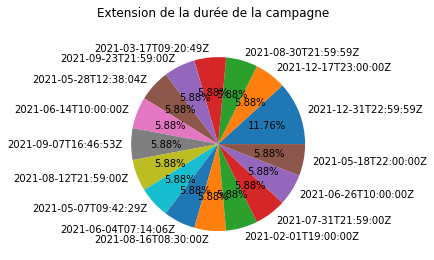

In [6]:
pie_feature("date_end_extra_time", "Extension de la durée de la campagne")

La colonne date_end_extra_time sera retirée car aucun projet ayant échoué n'y a fait appel et c'est un phénomène très minoritaire.

#### lowest_contribution_amount

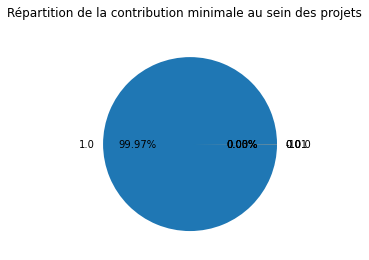

In [7]:
pie_feature("lowest_contribution_amount", "Répartition de la contribution minimale au sein des projets")

Etant quasiment constante, la colonne <b>lowest_contribution_amount</b> peut également être retirée car non pertinente.

###### committed

La colonne committed concerne les promesses faites par les supporters. Il y a deux cas de figure :
- Le projet est une campagne classique et les supporters promettent de l'argent (<b>amount_raised</b>) pour atteindre un objectif (<b>goal</b>). Dans ce cas, <b>committed</b> est strictement égal à <b>amount_raised</b>.
- Le projet est une prévente, les supporters promettent d'acheter un nombre de produits (<b>nb_products_sold</b>) pour atteindre un objectif de vente (<b>goal</b>). Dans ce cas, <b>committed</b> est strictement égal à <b>nb_products_sold</b>.

En conclusion, <b>committed</b> peut être retirée car inutile.

#### Données du projet

Ces données concernent le projet avant son lancement.

- analytics_count
- background
- ~comments_enabled~
- ~country~
- ~currency~
- ~currency_display~
- delivery
- ~description_ca~
- ~description_de~
- ~description_en~
- ~description_es~
- description_fr
- ~description_it~
- ~description_nl~
- ~description_pt~
- ~description_funding_ca~
- ~description_funding_de~
- ~description_funding_en~
- ~description_funding_es~
- description_funding_fr
- ~description_funding_it~
- ~description_funding_nl~
- ~description_funding_pt~
- goal
- goal_raised
- image
- ~lang~
- location
- main_image
- main_tag
- ~name_ca~
- ~name_de~
- ~name_en~
- ~name_es~
- name_fr
- ~name_it~
- ~name_nl~
- ~name_pt~
- owner
- payment_methods
- rewards
- sponsorships_count
- ~subtitle_ca~
- ~subtitle_de~
- ~subtitle_en~
- ~subtitle_es~
- subtitle_fr
- ~subtitle_it~
- ~subtitle_nl~
- ~subtitle_pt~
- visible
- video
- type
- ~timezone~

Il ne nous a pas semblé pertinent de garder la colonne <b>delivery</b> car elle peut ne pas avoir de sens si le projet n'offre pas de récompense physique (comme un jeu vidéo ou un film).

##### timezone

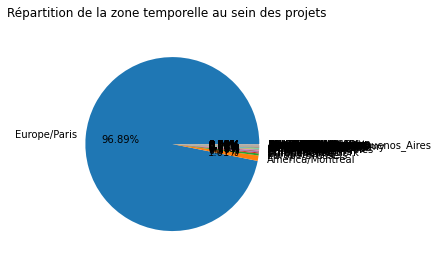

In [8]:
pie_feature("timezone", "Répartition de la zone temporelle au sein des projets")

L'immense majorité des projets a lieu dans la même zone, la colonne <b>timezone</b> est quasiment constante, elle peut être retirée.

##### comments_enabled

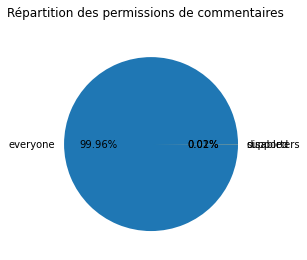

In [9]:
pie_feature("comments_enabled", "Répartition des permissions de commentaires")

Une écrasante majorité des projets autorise les commentaires pour tous les utilisateurs, la colonne <b>comments_enabled</b> n'est donc pas pertinente.

##### currency

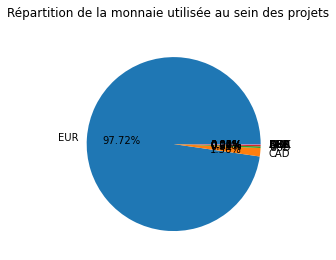

In [10]:
pie_feature("currency", "Répartition de la monnaie utilisée au sein des projets")

L'écrasante majorité des projets est en euro, il est donc possible de retirer la colonne <b>currency</b> ainsi que la colonne <b>currency_display</b>, sans oublier les projets concernés.

##### lang

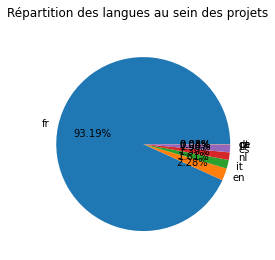

In [11]:
pie_feature("lang", "Répartition des langues au sein des projets")

Les autres langues que le français étant très minoritaires, on peut retirer tous les projets concernés ainsi que les colonnes suivantes :
- <b>description_[Langue!=fr]</b>
- <b>description_funding_[Langue!=fr]</b>
- <b>lang</b>
- <b>name_[Langue!=fr]</b>
- <b>subtitle_[Langue!=fr]</b>

## Nettoyage du set - Data preparation

### Retrait de lignes inutiles

In [12]:
unfinished_projets = data[~data.finished]
data.drop(unfinished_projets.index, inplace=True)

cancelled_projects = data[data.is_cancelled]
data.drop(cancelled_projects.index, inplace=True)

foreign_language_projects = data[data.lang != "fr"]
data.drop(foreign_language_projects.index, inplace=True)

not_euro_project = data[data.currency != "EUR"]
data.drop(not_euro_project.index, inplace=True)

foreign_country_project = data[data.country != "FR"]
data.drop(foreign_country_project.index, inplace=True)

### Retrait de colonnes inutiles

In [13]:
data.drop(columns=['absolute_url',
                   'address_required',
                   'phone_number_required',
                   'comments_enabled',
                   'committed',
                   'country',
                   'currency',
                   'currency_display',
                   'date_end_extra_time',
                   'delivery',
                   'description_ca',
                   'description_de',
                   'description_en',
                   'description_es',
                   'description_it',
                   'description_nl',
                   'description_pt',
                   'description_funding_ca',
                   'description_funding_de',
                   'description_funding_en',
                   'description_funding_es',
                   'description_funding_it',
                   'description_funding_nl',
                   'description_funding_pt',
                   'description_yourself_ca',
                   'description_yourself_de',
                   'description_yourself_en',
                   'description_yourself_es',
                   'description_yourself_it',
                   'description_yourself_nl',
                   'description_yourself_pt',
                   'discussions_thread_id',
                   'image',
                   'is_cancelled',
                   'is_in_extra_time',
                   'finished',
                   'lang',
                   'lowest_contribution_amount',
                   'main_image',
                   'name_ca',
                   'name_de',
                   'name_en',
                   'name_es',
                   'name_it',
                   'name_nl',
                   'name_pt',
                   'orders_count',
                   'required_personal_id_number',
                   'resource_uri',
                   'sharing_urls',
                   'slug',
                   'subtitle_ca',
                   'subtitle_de',
                   'subtitle_en',
                   'subtitle_es',
                   'subtitle_it',
                   'subtitle_nl',
                   'subtitle_pt',
                   'time_left', 
                   'time_left_short',
                   'timezone',
                   'urls',
                   'user_role'], inplace=True)

### Bilan : colonnes restantes
Les colonnes suivantes sont conservées dans le dataset, mais peuvent nécessiter un travail supplémentaire, comme la colonne <b>video</b>. Nous n'allons en effet pas étudier la vidéo du projet en elle même mais plutôt le fait qu'elle existe ou non par exemple.

Le set contient une trentaine de colonnes pour environs 40.000 projets.

In [14]:
data.columns

Index(['amount_raised', 'analytics_count', 'background', 'comments_count',
       'date_end', 'date_goal_raised', 'date_start', 'description_fr',
       'description_funding_fr', 'description_yourself_fr', 'fans_count',
       'goal', 'goal_raised', 'id', 'location', 'main_tag', 'name_fr',
       'nb_days', 'nb_products_sold', 'news_count', 'owner', 'payment_methods',
       'percent', 'rewards', 'sponsorships_count', 'subtitle_fr',
       'supporters_count', 'type', 'video', 'visible'],
      dtype='object')

### Transformations de certaines données

Certaines colonnes doivent être binarisée pour représenter ou non la présence d'un objet (comme une vidéo).

In [15]:
def binarize(x):
    return 1 if type(x) == str else 0

data.background = data.background.apply(binarize)
data.video = data.video.apply(binarize)

La colonne owner est inutilisable en tant que telle car seules les stats <b>anonymisées et concernant l'activité publique de lancement de projet</b> de l'owner nous intéressent.

In [16]:
def recup_in_str_owner(x):
    return ast.literal_eval(x['owner'])['stats']
    

data['owner'] = data.apply(recup_in_str_owner, axis = 1)

##### rewards

Pour chaque projet, l'attribut reward propose un certain nombre de rewards dans une liste. Pour chaque reward, plusieurs informations sont disponibles, comme une date de livraison, un nombre de stock etc. Il est possible pour une reward d'avoir plusieurs variantes, par exemple une couleur pour un T-shirt, localisé dans l'attribut 'variants'.

Les stocks seront toujours nuls (les projets sont finis) mais il est possible de savoir combien de chacune des rewards ont été prises, et à quel prix. Il est donc possible de voir, pour un projet, ce qui a été le plus rentable i.e. plein de petites rewards ou peu de grosses; et de croiser avec tous les autres projets.

La colonne doit donc être retravaillée pour extraire une liste de dictionnaires par projet. <b>Attention, l'exécution est longue !</b>

In [17]:
def recup_in_str_rewards(x):
    allowed_keys = ["description_fr", "id", "price", "stock_taken", "variants"]
    allowed_keys_variants = ["description_fr", "id", "price", "stock_taken"]
    rewards_dict_list = ast.literal_eval(x["rewards"])
    for dictionnary in rewards_dict_list:
        if "variants" in dictionnary:
            dictionnary["variants"] = [{key:val for key, val in variant.items() if key in allowed_keys_variants} for variant in dictionnary["variants"]]
    
    return [{key:val for key, val in dictionnary.items() if key in allowed_keys} for dictionnary in rewards_dict_list]

data['rewards'] = data.apply(recup_in_str_rewards, axis = 1)

##### main_tag
Dans la mesure où les projets ne se comportent pas de la même façon selon leur type, il peut être intéressant d'étudier les tags utilisés pour les décrire. Seuls nous intéressent l'id et le nom en français du tag, il faut donc les extraire.

In [18]:
def recup_in_str_main_tag(x):
    if type(x["main_tag"]) == str:
        return {key:val for key, val in ast.literal_eval(x["main_tag"]).items() if key == 'name_fr' or key == 'id'}

data["main_tag"] = data.apply(recup_in_str_main_tag, axis=1)

### Retrait de lignes incomplètes

In [19]:
essentials_columns_names = ['date_start', 'date_end', 'amount_raised', 'comments_count', 'date_start', 'date_end', 'description_fr',
       'description_funding_fr', 'description_yourself_fr', 'fans_count',
       'goal', 'goal_raised', 'id', 'main_tag', 'name_fr', 'news_count', 'owner', 'percent',
       'rewards', 'sponsorships_count', 'subtitle_fr', 'supporters_count']

for col_name in essentials_columns_names:
    index = data.columns.get_loc(col_name)
    index_with_nan = data.index[data.iloc[:,index].isnull()]
    print("Retrait de {} lignes n'ayant aucun valeur dans la colonne {}".format(len(index_with_nan), col_name))
    data.drop(labels=index_with_nan, inplace=True)

Retrait de 38 lignes n'ayant aucun valeur dans la colonne date_start
Retrait de 0 lignes n'ayant aucun valeur dans la colonne date_end
Retrait de 0 lignes n'ayant aucun valeur dans la colonne amount_raised
Retrait de 0 lignes n'ayant aucun valeur dans la colonne comments_count
Retrait de 0 lignes n'ayant aucun valeur dans la colonne date_start
Retrait de 0 lignes n'ayant aucun valeur dans la colonne date_end
Retrait de 2 lignes n'ayant aucun valeur dans la colonne description_fr
Retrait de 714 lignes n'ayant aucun valeur dans la colonne description_funding_fr
Retrait de 399 lignes n'ayant aucun valeur dans la colonne description_yourself_fr
Retrait de 0 lignes n'ayant aucun valeur dans la colonne fans_count
Retrait de 0 lignes n'ayant aucun valeur dans la colonne goal
Retrait de 0 lignes n'ayant aucun valeur dans la colonne goal_raised
Retrait de 0 lignes n'ayant aucun valeur dans la colonne id
Retrait de 53 lignes n'ayant aucun valeur dans la colonne main_tag
Retrait de 0 lignes n'aya

La colonne "nb_days" contient un tiers de valeurs vides, il faut la compléter.

In [20]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%Y-%m-%d")
    d2 = datetime.strptime(d2, "%Y-%m-%d")
    return abs((d2 - d1).days)

data['nb_days'] = [days_between(data.date_start[k][0:10], data.date_end[k][0:10]) for k in data.date_start.index]

Les projets fonctionnent différemment selon qu'ils concernent des préventes ou une financement. Il convient donc de séparer le set en deux sous-sets.

In [21]:
data_presolds = data[data['type'] == 1]
data = data[data['type'] == 2]

data.drop(columns="nb_products_sold", inplace=True) # Strictement équivalent au nombre de participants

## Statistiques descriptives - Modeling (à revoir et trier, certaines doivent aller avant le nettoyage)

##### fans_count

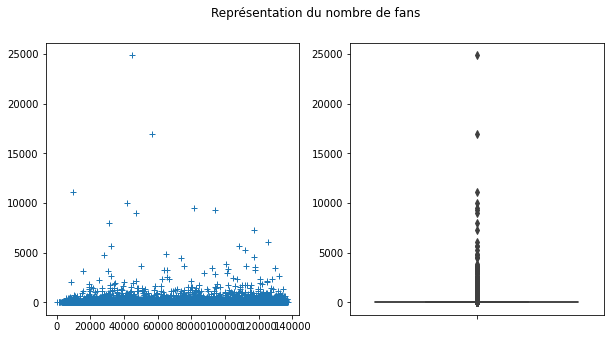

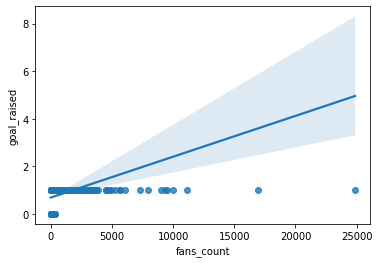

SpearmanrResult(correlation=0.23801210357688027, pvalue=0.0)

In [22]:
plot_feature("fans_count", "Représentation du nombre de fans","","")

plt.figure()
sns.regplot(x="fans_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['fans_count'])


La présence de fans semble être un phénomène très minoritaire, il serait intéressant de vérifier si les projets suivis ont été plus réussis que les autres.
Il est possible de conclure quand à l'existence d'une corrélation entre le succès de la campagne et le nombre de fans.

##### goal_raised

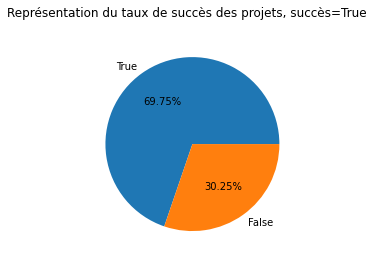

In [23]:
pie_feature("goal_raised", "Représentation du taux de succès des projets, succès=True")

Pour rappel, le taux de succès des projets de la plateforme en 2021 est de 79%.

##### payment_methods

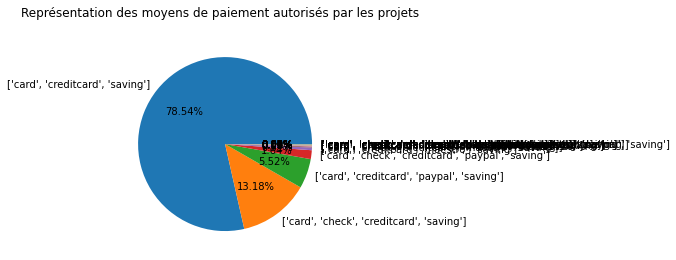

SpearmanrResult(correlation=nan, pvalue=nan)

In [24]:
pie_feature("payment_methods", "Représentation des moyens de paiement autorisés par les projets")

spearmanr(data['goal_raised'], data['payment_methods'])

La totalité autorise le trio "card, creditcard, saving" et 75% l'utilisent.
Il ne semble y avoir aucune corrélation entre le moyen de paiement et le succès de la campagne.

##### sponsorships_count

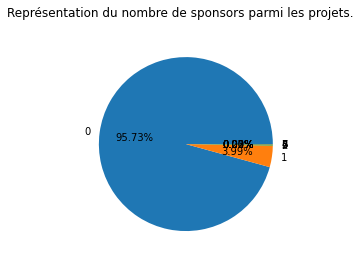

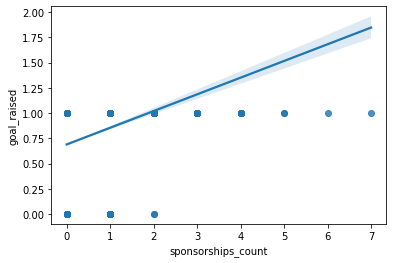

SpearmanrResult(correlation=0.08702283941347953, pvalue=2.327453224724688e-63)

In [25]:
pie_feature("sponsorships_count", "Représentation du nombre de sponsors parmi les projets.")

plt.figure()
sns.regplot(x="sponsorships_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['sponsorships_count'])

L'obtention de sponsors semble être un phénomène très minoritaire.
Il ne semble pas y avoir de corrélation entre le succès de la campagne et la présence de sponsors.

##### amount_raised

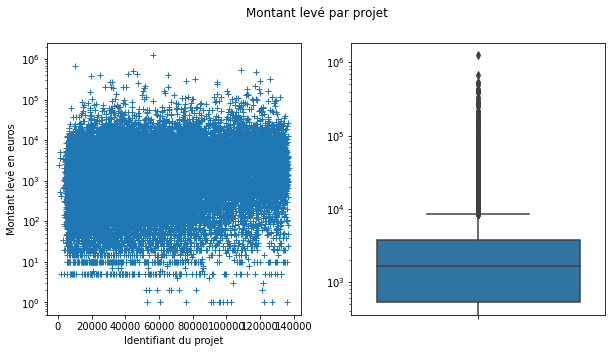

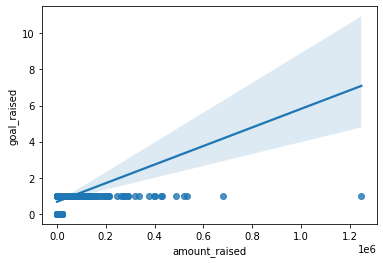

SpearmanrResult(correlation=0.6606095954569525, pvalue=0.0)

In [26]:
def plot_feature_log(feature_name, title, xlabel, ylabel):
    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    plt.suptitle(title)
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlabel(xlabel)
    ax1.set_ylabel(ylabel)
    ax1.plot(data.id, data[feature_name], "+")

    sns.boxplot(y=data[feature_name], ax=ax2)
    ax2.set_ylabel("")
    plt.show()

plot_feature_log("amount_raised", "Montant levé par projet", "Identifiant du projet", "Montant levé en euros")

plt.figure()
sns.regplot(x="amount_raised", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['amount_raised'])

Les projets semblent assez homogènes dans les montants levés même si moins nombreux pour les plus hauts montants.
Il semble y avoir une bonne corrélation entre le montant obtenu et le succès de la campagne (peu surprenant).

##### comments_count

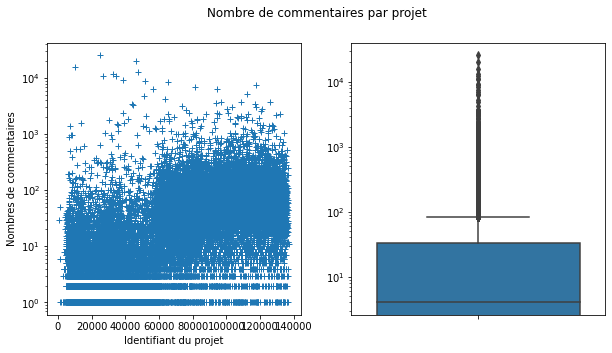

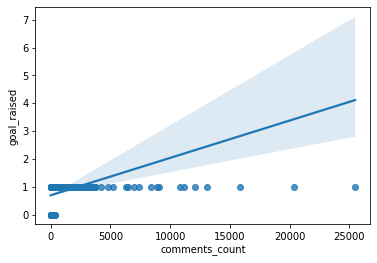

SpearmanrResult(correlation=0.3443645794824624, pvalue=0.0)

In [27]:
plot_feature_log("comments_count", "Nombre de commentaires par projet", "Identifiant du projet", "Nombres de commentaires")

plt.figure()
sns.regplot(x="comments_count", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['comments_count'])

Les projets reçoivent globalement assez peu de commentaires. La plupart des projets qui ont beaucoup de commentaires, ont bien fonctionné.
Il semble y avoir une petite corrélation entre le nombre de commentaires et le succès de la campagne.

##### goal

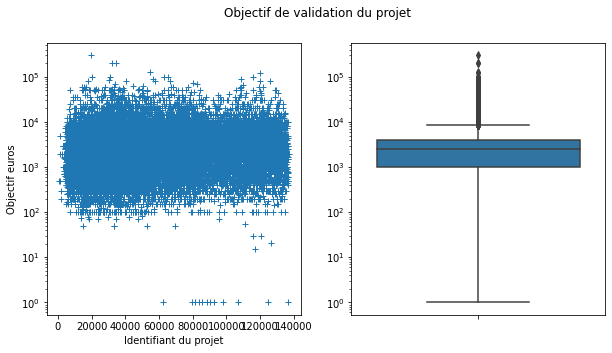

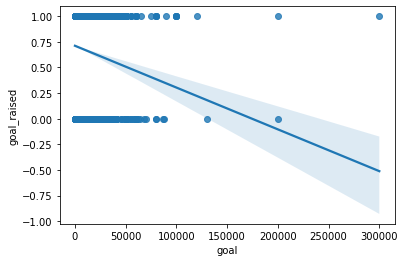

SpearmanrResult(correlation=-0.07463493929776771, pvalue=4.908846807091178e-47)

In [28]:
plot_feature_log("goal", "Objectif de validation du projet", "Identifiant du projet", "Objectif euros")

plt.figure()
sns.regplot(x="goal", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['goal'])

La majorité des projets semble se concentrer autour de la même fourchette de valeur, malgré quelques valeurs extrêmes.
Il ne semble pas y avoir de corrélation entre le montant de succès de la campagne et son succès.

##### nb_days

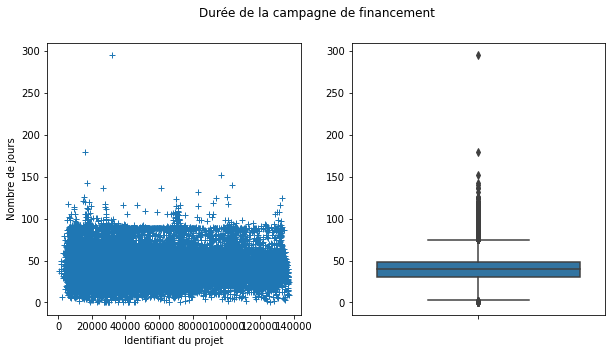

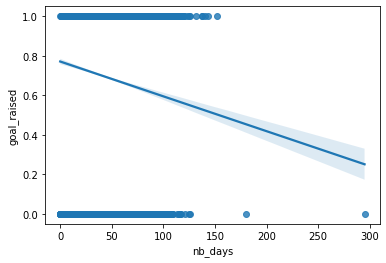

SpearmanrResult(correlation=-0.060303726217880396, pvalue=2.825745418641079e-31)

In [29]:
plot_feature("nb_days", "Durée de la campagne de financement", "Identifiant du projet", "Nombre de jours")

plt.figure()
sns.regplot(x="nb_days", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['nb_days'])

Les campagnes semblent durer plus ou moins un mois en grande majorité.
Il ne semble n'y avoir aucune corrélation entre la durée de la campagne et son succès.

##### news_count

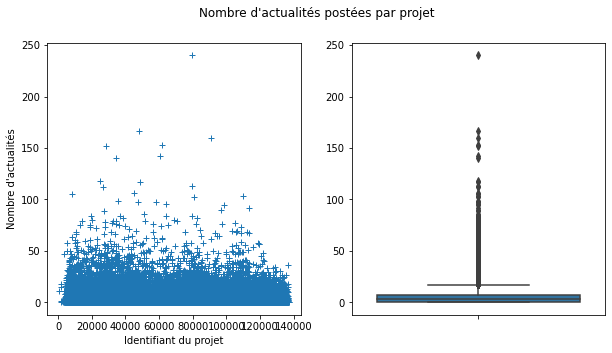

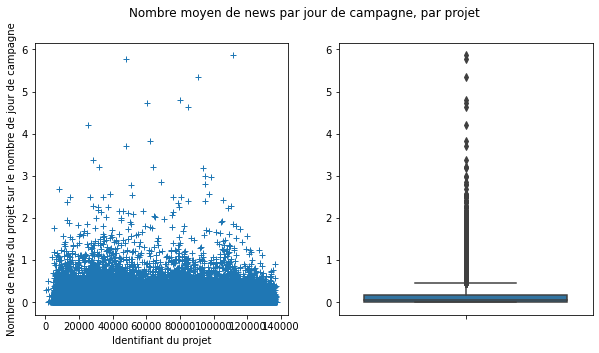

/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1396: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


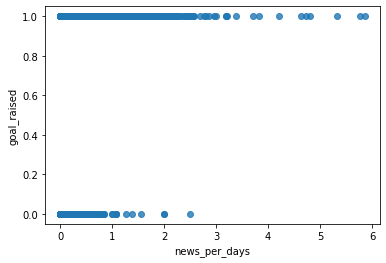

SpearmanrResult(correlation=0.4499341851863299, pvalue=0.0)

In [30]:
plot_feature("news_count", "Nombre d'actualités postées par projet", "Identifiant du projet", "Nombre d'actualités")
col = (data["news_count"]/data["nb_days"]).apply(lambda x : 0 if np.isnan(x) else x)
data["news_per_days"] = col

plot_feature("news_per_days", "Nombre moyen de news par jour de campagne, par projet","Identifiant du projet","Nombre de news du projet sur le nombre de jour de campagne")

plt.figure()
sns.regplot(x="news_per_days", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['news_per_days'])

Un certain nombre de projets ne donne aucune nouvelle durant la campagne, la grande majorité n'en donne pas plus de cinq durant toute la campagne. La grande majorité des projets ne donne qu'une news tous les dix jours, au mieux.
Il semble y avoir une légère corrélation entre le nombre de news par jour et le succès de la campagne.

##### percent

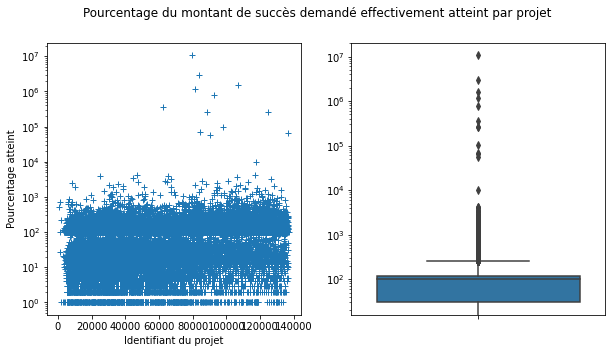

In [31]:
plot_feature_log("percent", "Pourcentage du montant de succès demandé effectivement atteint par projet", "Identifiant du projet", "Pourcentage atteint")

On note trois catégories de projets : 
- ceux qui échouent complétement (moins de 50% du montant demandé sont atteints)
- ceux qui réussissent "normalement" (entre 100% et 175% du montant demandé sont atteints)
- ceux qui réussissent "fortement" (au-delà de 200%)

##### supporters_count

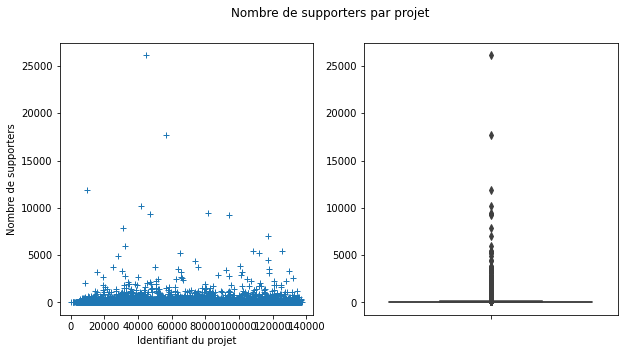

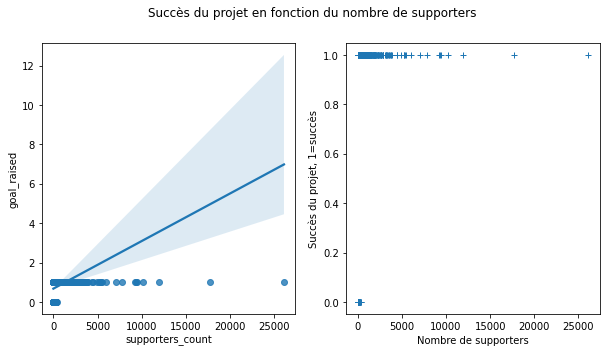

SpearmanrResult(correlation=0.6697910870493309, pvalue=0.0)

In [32]:
plot_feature("supporters_count", "Nombre de supporters par projet", "Identifiant du projet", "Nombre de supporters")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.regplot(x="supporters_count", y="goal_raised", data=data, ax=ax1)

f.suptitle("Succès du projet en fonction du nombre de supporters")
ax2.set_xlabel("Nombre de supporters")
ax2.set_ylabel("Succès du projet, 1=succès")
ax2.plot(data.supporters_count, data.goal_raised, "+")
plt.show()

spearmanr(data['goal_raised'],data['supporters_count'])

On constate une bonne corrélation entre le succès du projet et le nombre de supporters.

##### analytics_count

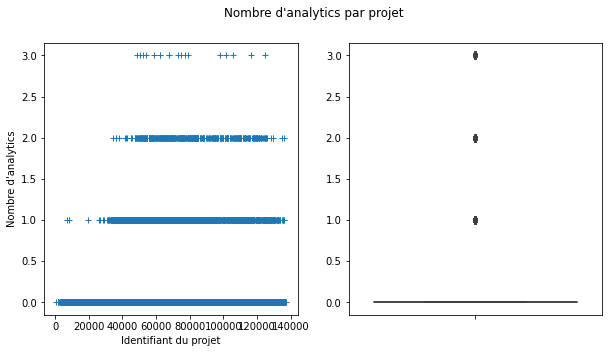

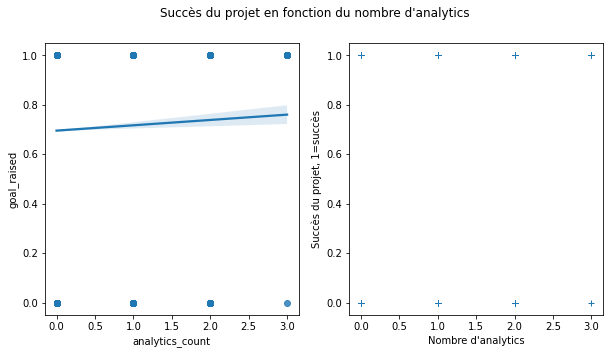

SpearmanrResult(correlation=0.006612762989151497, pvalue=0.2025156476844547)

In [33]:
plot_feature("analytics_count", "Nombre d'analytics par projet", "Identifiant du projet", "Nombre d'analytics")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.regplot(x="analytics_count", y="goal_raised", data=data, ax=ax1)

f.suptitle("Succès du projet en fonction du nombre d'analytics")
ax2.set_xlabel("Nombre d'analytics")
ax2.set_ylabel("Succès du projet, 1=succès")
ax2.plot(data.analytics_count, data.goal_raised, "+")
plt.show()

spearmanr(data['goal_raised'],data['analytics_count'])

On constate qu'il n'y a pas de corrélation entre le nombre d'analytics et la réussite d'un projet

##### visible

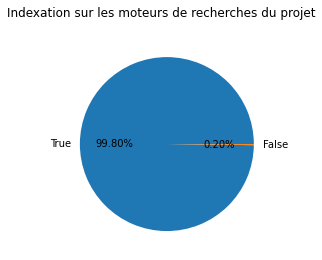

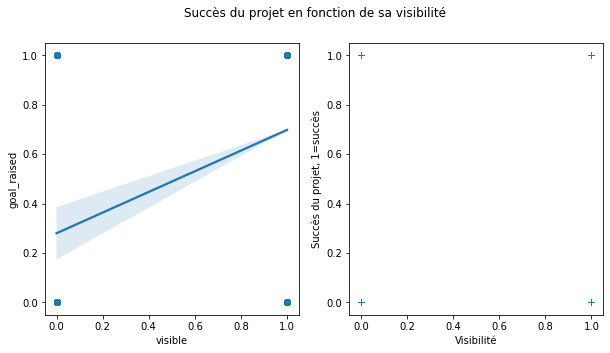

SpearmanrResult(correlation=0.04088305049966668, pvalue=3.216051349568124e-15)

In [34]:
pie_feature("visible", "Indexation sur les moteurs de recherches du projet")

f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
sns.regplot(x="visible", y="goal_raised", data=data, ax=ax1)

f.suptitle("Succès du projet en fonction de sa visibilité")
ax2.set_xlabel("Visibilité")
ax2.set_ylabel("Succès du projet, 1=succès")
ax2.plot(data.visible, data.goal_raised, "+")
plt.show()

spearmanr(data['goal_raised'],data['visible'])

La plupart des projets sont indexés sur les moteurs de recherches.
On ne constate cepandant pas de corrélation entre la visibilité et le succès d'un projet

##### video

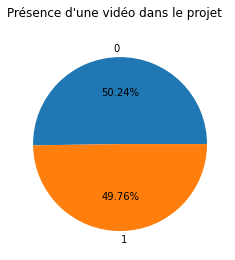

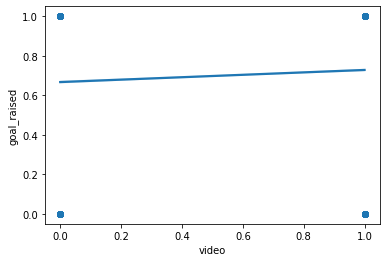

SpearmanrResult(correlation=0.06664603134365685, pvalue=7.732344713082965e-38)

In [35]:
pie_feature("video", "Présence d'une vidéo dans le projet")

plt.figure()
sns.regplot(x="video", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['video'])

Il ne semble pas y avoir de corrélation entre le fait de posséder une vidéo et le succès de la campagne

##### background

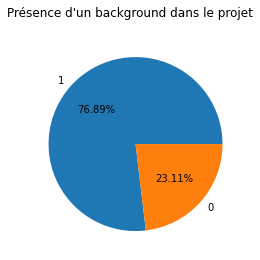

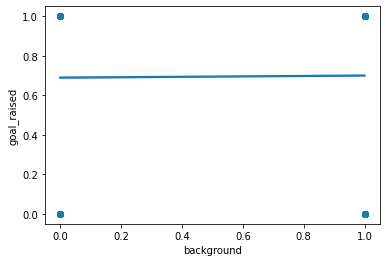

SpearmanrResult(correlation=0.009675839501213698, pvalue=0.06221520326888963)

In [36]:
pie_feature("background", "Présence d'un background dans le projet")

plt.figure()
sns.regplot(x="background", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['background'])

Il n'y a pas de corrélation entre la présence d'un background et le succès de la campagne.

##### main_tag

[]

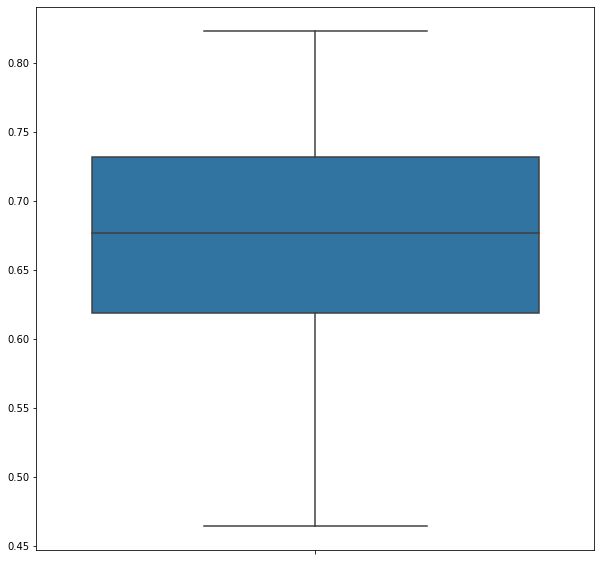

In [37]:
dict_percent_success = {}

for index, main_tag in zip(data.main_tag.index, data.main_tag):
    goal_was_raised = 1 if data.goal_raised[index] else 0
    if main_tag["id"] not in dict_percent_success:
        dict_percent_success[main_tag["id"]] = [1, goal_was_raised]
    else:
        nb_project, nb_success = dict_percent_success[main_tag["id"]]
        nb_project += 1
        nb_success += goal_was_raised
        dict_percent_success[main_tag["id"]] =  [nb_project, nb_success]

for index, value in dict_percent_success.items():
    dict_percent_success[index] = value[1]/value[0]

plt.figure(figsize=(10,10))
sns.boxplot(y=list(dict_percent_success.values()))
plt.plot()

DOCUMENTATION SUR TAUX DE SUCCES

In [53]:
[data.owner[k]['created_projects_online_count'] for k in data.owner.index]

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 5,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 15,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 7,
 2,
 2,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 5,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 8,
 1,
 4,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 44,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 5,
 2,
 2,
 1,
 1,
 1,
 11,
 1,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 4,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 15,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 1,
 1,


##### rewards

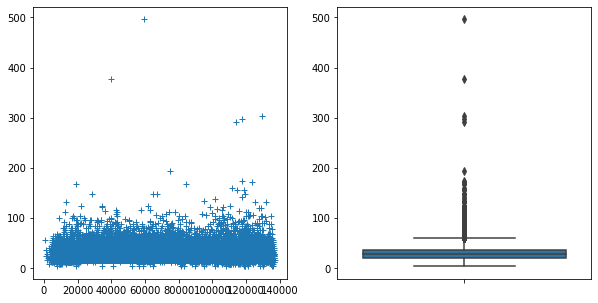

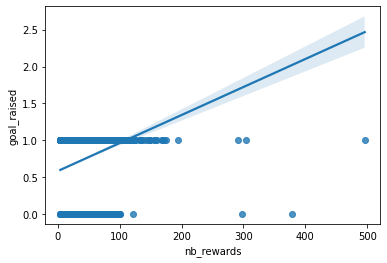

SpearmanrResult(correlation=0.11316244428205077, pvalue=4.133365904417858e-106)

In [38]:
def get_nb_rewards(index_project):
    nb = 0
    for dictionnary in data.rewards[index_project]:
        nb += len(dictionnary.keys())
    return nb

list_nb_reward = [get_nb_rewards(k) for k in data.rewards.index]
data["nb_rewards"] = list_nb_reward
plot_feature("nb_rewards", "", "", "")

plt.figure()
sns.regplot(x="nb_rewards", y="goal_raised", data=data)
plt.show()

spearmanr(data['goal_raised'], data['nb_rewards'])

On appellera dans ce qui suit "meilleure récompense", la récompense maximisant le rapport de son prix sur le nombre d'achat. Ainsi une récompense vendue une seule fois à 500€ est meilleure qu'une récompense vendue 100 fois à 2€.

In [39]:
def get_best_reward_index(project_index):
    rewards_outcomes_list = [reward["price"]*reward["stock_taken"] for reward in data.rewards[project_index]]
    index = rewards_outcomes_list.index(max(rewards_outcomes_list))
    return index

best_reward_dict_price = {}
best_reward_dict_nb = {}
for index in data.rewards.index:
    index_reward = get_best_reward_index(index)
    best_reward_dict_price[index] = data.rewards[index][index_reward]["price"]
    best_reward_dict_nb[index] = data.rewards[index][index_reward]["stock_taken"]

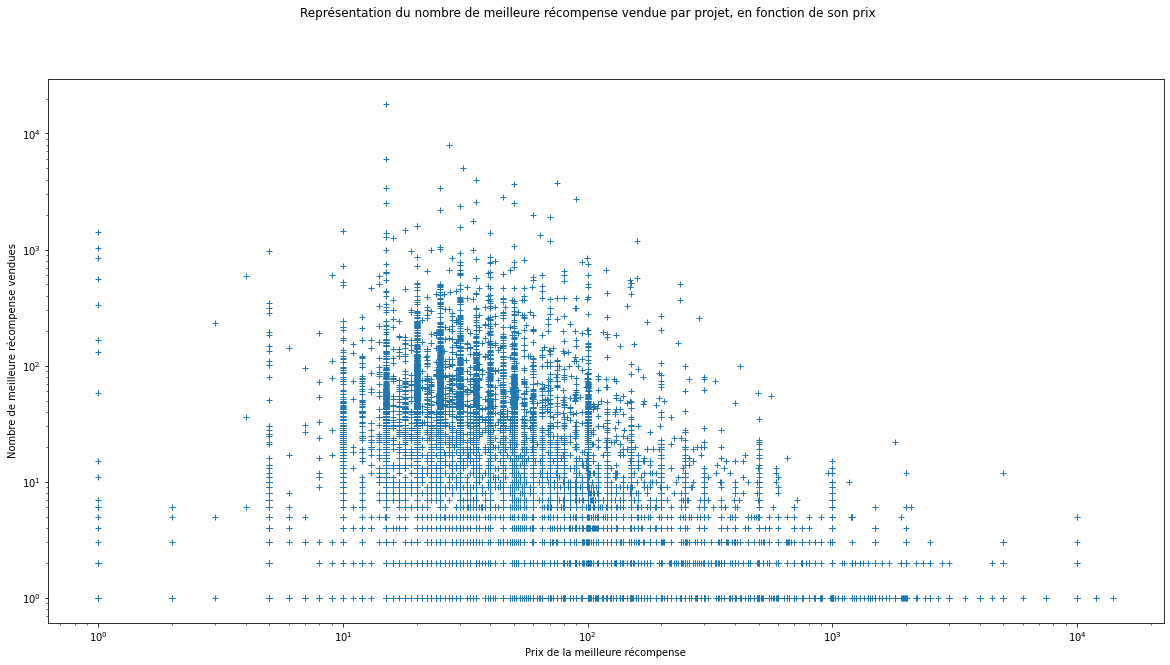

In [40]:
plt.figure(figsize=(20,10))
list_prices = [best_reward_dict_price[key] for key in sorted(best_reward_dict_price.keys())]
list_nb = [best_reward_dict_nb[key] for key in sorted(best_reward_dict_nb.keys())]
plt.loglog(list_prices, list_nb, '+')
plt.xlabel("Prix de la meilleure récompense")
plt.ylabel("Nombre de meilleure récompense vendues")
plt.suptitle("Représentation du nombre de meilleure récompense vendue par projet, en fonction de son prix")
plt.show()

Les récompenses les plus rentables des projets semblent se situer entre 10 et 100€, pour une centaine de vente.

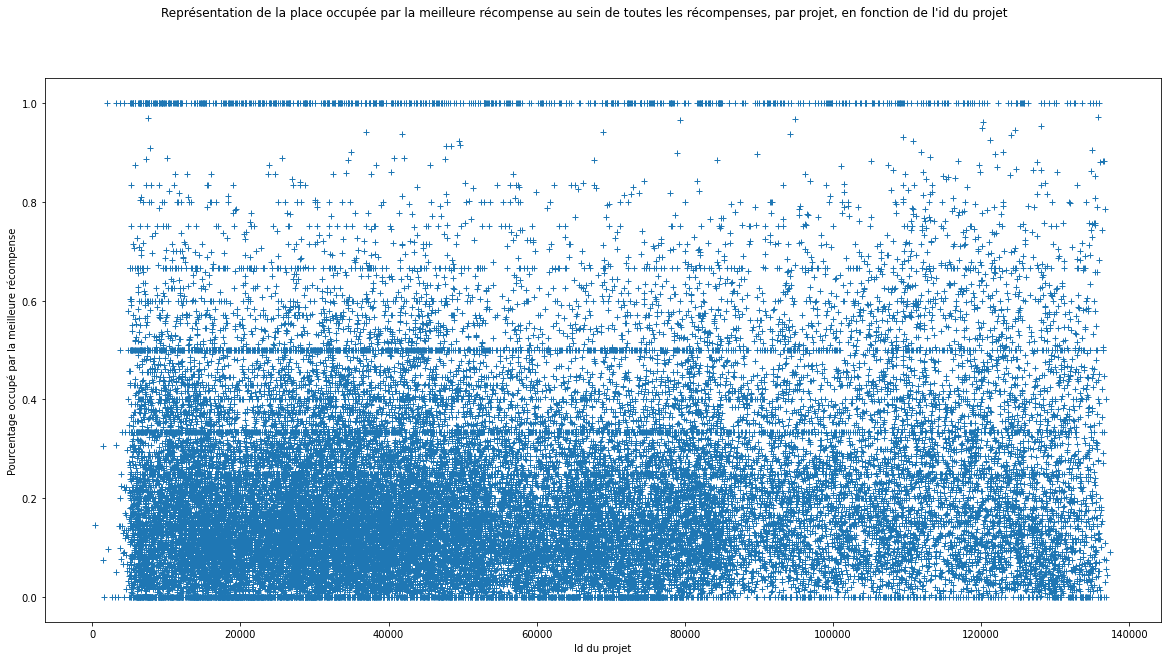

In [41]:
percentage_best_reward = [best_reward_dict_nb[k]/data.supporters_count[k] if data.supporters_count[k] != 0 and best_reward_dict_nb[k] <= data.supporters_count[k] else 0 for k in data.supporters_count.index]
plt.figure(figsize=(20,10))
plt.plot(data.id, percentage_best_reward, "+")
plt.suptitle("Représentation de la place occupée par la meilleure récompense au sein de toutes les récompenses, par projet, en fonction de l'id du projet")
plt.xlabel("Id du projet")
plt.ylabel("Pourcentage occupé par la meilleure récompense")
plt.show()

<b>Je ne sais pas du tout comment interpréter ça, help svp</b>

## A FAIRE

Enlever les extrêmes

Faire des trucs avec: les dates, main_tag, rewards, owner

Multi corrélation avec une seule variable

Mettre à jour ci-dessous \/

/home/raphaelcaby13/.virtualenvs/machinelearning/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


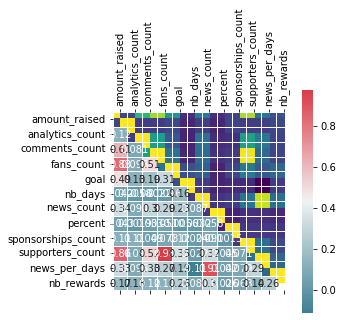

In [42]:
corr_df = data.copy(deep=True)
corr_df.drop(columns=['id', 'type', 'background', 'date_goal_raised', 'date_start', 'description_fr', 'description_funding_fr', 'description_yourself_fr', 'goal_raised', 'location', 'main_tag', 'name_fr', 'owner', 'payment_methods', 'rewards', 'subtitle_fr', 'video', 'visible'], inplace=True)
plt.matshow(corr_df.corr())

def plot_corr(corr):
    plt.rc('figure', figsize=[15, 15])
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, linewidth=0.5, square=True)
    plt.show()

plot_corr(corr_df.corr())